# Connecting to Google Drive

The first step is to get access to storage for the practice. We'll use a directory located in our Google Drive, as for example `"AMLCV/P2/tutorial/"`.

First, we connect the notebook with our Google Drive. Run `drive.mount` with a route, and it will ask for an authorization code that you can get from the URL.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


Then, we can change the working directory to the project route, like "AMLCV/P2/tutorial/" in our Drive. This will allow us to use relative routes to access our data and to write our results.

In [2]:
route = '/content/gdrive/MyDrive/AMLCV/P2/tutorial'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}''")
%cd $route
!pwd

print("\nAnd here there are our files:")
!ls -lasth



Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/AMLCV/P2/tutorial''
/content/gdrive/MyDrive/AMLCV/P2/tutorial
/content/gdrive/MyDrive/AMLCV/P2/tutorial

And here there are our files:
total 310K
154K -rw------- 1 root root 154K Apr 13 14:37 '01. MNIST starter tutorial.ipynb'
156K -rw------- 1 root root 156K Apr 12 16:09 '02. MNIST Segmentation Dataset'


# Loading a torchvision dataset

The torchvision library contains several [image datasets](https://pytorch.org/vision/stable/datasets.html), ready to use. We will load and use the [MNIST](https://pytorch.org/vision/stable/datasets.html#mnist) digit classification dataset.

The API allows to directly download it in a given route. We will the project directory that we have stored in the `route` variable.

In [3]:
from torchvision import datasets

train = datasets.MNIST(route, train=True, download=True)
test = datasets.MNIST(route, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw




Extracting /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw




Extracting /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/AMLCV/P2/tutorial/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Now the dataset is ready to use from objects `test` and `train`, which are a subclass of [Dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets), and it will define a *pythonic* [`__getitem__()`](https://docs.python.org/3.7/reference/datamodel.html#object.__getitem__) function allowing to iterate over it, and usually a [`__len__()`](https://docs.python.org/3.7/reference/datamodel.html#object.__len__) one.

In [ ]:
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/gdrive/MyDrive/AMLCV/P2/tutorial
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/gdrive/MyDrive/AMLCV/P2/tutorial
    Split: Test


10000
(<PIL.Image.Image image mode=L size=28x28 at 0x7F885AA18790>, 7)


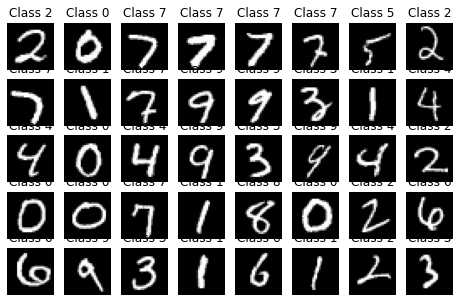

In [4]:
import matplotlib.pyplot as plt
from numpy import random

print(len(test))
print(test[0])

view = random.permutation(100)
rows = 5
cols = 8

fig, axes = plt.subplots(rows, cols,figsize =(cols, rows) )

count=0
for ax in axes.reshape(-1):
  sample, label = test[view[count]]
  count += 1
  ax.imshow(sample, cmap='gray')
  ax.axis('off')
  ax.title.set_text(f'Class {label}')



# Loading a torchvision model



The torchvision library also contains several [network models](https://pytorch.org/vision/stable/models.html), ready to use and with the weights pre-trained. We will load and use the [VGG-16](https://pytorch.org/vision/stable/models.html#id2) model, which is pre-trained on ImageNet.

We can also load the model with random weights.

In [5]:
from torchvision import models

vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


We can now explore, modify and use the loaded model. 

This model is composed of blocks of two/three [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) 3x3 layers of N channels, followed by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) activation, and a final [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) layer that decimates the image by 2. There are 5 blocks of this type, with doubling number of channels from N=64 up to N=512. The convolutional block is stored into a [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) module called `features`.

The classifier head is also stored in a [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) module (`classifier`). The model expects an input vector of 25.088 features, which results from applying the features module to a 128x128 image (512x7x7). This model is composed of several fully-connected [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layers, followed by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) activation and [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout). The output layer is a fully-connected [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer with 1000 class outputs.

Additionally, this PyTorch implementation offers these features:

*   An [AddaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d) 7x7 layer between the `features` convolutional trunc, and the `classifier` fully-connected head. This allows to have 512x7x7 features. Thus, it doesn't matter if the input image is larger than 128x128.
*   The ouput layer is linear, which provides the output logits for 1000 classes. In order to obtain a classification probability we should add a [SoftMax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax) or a [SoftMax2d](https://pytorch.org/docs/stable/generated/torch.nn.Softmax2d.html#torch.nn.Softmax2d) layer on top of it.



In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We can test the network with images from the MNIST dataset that we've loaded. It is not expected to o anything useful, as it the network is trained on ImageNet.

However, this network expects RGB images of 128x128, and the MNIST images are of 1 channel and 28x28 pixels. We are going resize the images to 128x128 and convert them to RGB using the [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) library.

In [10]:
from torchvision import transforms as t

trans = t.Compose([
                   t.Lambda(lambda x: x.convert("RGB")),
                   t.Resize(128),
                   t.ToTensor()
])

input, target = test[0]
print("This is the dataset 'input'")
print(input)

input = trans(input).unsqueeze_(0) 
#  The unsqueeze is because the network need an input of [N,3,W,H], 
# where N is the number of training/testing images: in this case 1.
# The transform output will be a PyTorch tensor of shape [3,128,128].
# The unsqueeze gives a tensor of shape [1,3,128,128].

print("\nThis is the transformed 'input'")
print(input.shape)

output = vgg(input)

print("\nThis is the output of the network")
print(output.shape)

This is the dataset 'input'
<PIL.Image.Image image mode=L size=28x28 at 0x7F8858105BD0>

This is the transformed 'input'
torch.Size([1, 3, 128, 128])

This is the output of the network
torch.Size([1, 1000])


# Adapting the loaded model

Modify the model to classify 10 digits. We will get the convolutional trunc, with a global average pooling along the image, and we will attach fully-connected layers of 1024 and 10 neurons each as classification head. 

In [11]:
from torch import nn

vggf = vgg.features

mymodel = nn.Sequential(
    vggf,
    nn.AdaptiveAvgPool2d(output_size = 1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)

output = mymodel(input)
print(output.shape)



torch.Size([1, 10])


We will additionally adapt the number of input channels to 1. Intizalizing the new gray-level kernels as the sum along channels of the RGB kenels in the pre-trained network.


In [12]:
print(mymodel[0][0])
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

old_layer = mymodel[0][0]
mymodel[0][0] = nn.Conv2d(1, 64, 3, padding=1)
mymodel[0][0].weight.data = old_layer.weight.sum(dim=1, keepdim=True)
mymodel[0][0].bias.data = old_layer.bias

print(mymodel[0][0])
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")


Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
- weight: torch.Size([64, 3, 3, 3])
- bias: torch.Size([64])
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
- weight: torch.Size([64, 1, 3, 3])
- bias: torch.Size([64])


# A new model from scratch

To define a new model from scratch it is convenient to define a nn.Module subclass.

We just need to define the constructor and the `forward` method. The backward method is automatically computed using `autograd` from the execution graph.


In [13]:
class myCNN(nn.Module):
    
    def __init__(self):
        super(myCNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(64*6*6,600), # We assume the 6x6 resulting from input images of 28x28
            nn.ReLU()
            )

        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6) # Like flattening in-place
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x,dim=1)

Now we can make an instance of this model and play with it.

Please note that the layers will be initialized with the default random parameters, which can be changed to user-defined approaches. For example, for conv layers activated with ReLU, it is more convenient to use the [Kaiming He Uniform](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization, but for TanH layers it is better to follow the [Xavier Glorot](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_) one.

In [14]:
mycnn = myCNN()

print(mycnn)


myCNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


# Loading data for training 





The PyTorch [Datasets](https://pytorch.org/vision/stable/datasets.html#mnist) allow to add a set of [transforms](https://pytorch.org/vision/stable/transforms.html) that should be applied to the data.

In [15]:
mytransforms = t.Compose([
                          t.Resize(64),
                          t.ToTensor(),
                          t.Normalize((0.5,),(0.5,))
])

test = datasets.MNIST(route, train=False, download=True, transform = mytransforms)



The Dataset transforms can be random, so that each time the dataset returns a given image, there is a random transform applied. This can be used to implement online data augmentation during training.

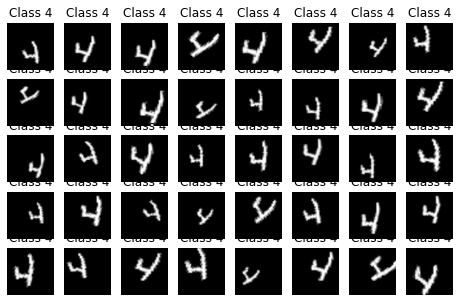

In [18]:
myaugmentation = t.Compose([
                             t.Pad(4),
                             t.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.75,1.25), shear=15),
                             t.ColorJitter(brightness=(0.2,0.8), contrast=(0.2, 0.8)),
                             mytransforms
])

train = datasets.MNIST(route, train=True, download=True, transform=myaugmentation)

sample_idx = random.randint(0, len(train))
rows = 5
cols = 8

fig, axes = plt.subplots(rows, cols,figsize =(cols, rows) )

# Loading the same sample over and over again gives different transforms
for axrow in axes:
  for ax in axrow:
    sample,label = train[sample_idx]
    ax.imshow(sample[0,...], cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Class {label}')


Additionally, it is convenient to access the Datasets using a [DataLoader]https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). This will allow to load the data randomized and in batches, ready to use by the network. 

In [19]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

#We can iterate over the dataset as:
counter = 0
for sample, target in dataloader:
  print(f"Minibacth {counter}: ({sample.shape}, {target.shape}).")
  counter += 1
  if counter == 10:
    print("... It would continue for much longer until an epoch is completed.")
    break
  

Minibacth 0: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 1: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 2: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 3: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 4: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 5: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 6: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 7: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 8: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 9: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
... It would continue for much longer until an epoch is completed.


# Training the network

PyTorch includes an automatic differenciation engine [autograd](https://pytorch.org/docs/stable/autograd.html)). This allows to compute the backpropagation gradients easily. 


In [21]:
# Autograd Example. Make two tensors and operate with them
import torch

a = torch.tensor([1., 2.], requires_grad=True)
b = torch.tensor([5., 6.], requires_grad=True)

# Look at the current gradients
print(f"Tensor 'a': {a}")
print(f"Gradients wrt tensor 'a': {a.grad}")

print(f"Tensor 'b': {b}")
print(f"Gradients wrt tensor 'b': {b.grad}")

# Pass it through the "network"

q = 3*a**3-b**2           # 3a^3-b^2 -> dq/da = 9a^2 ; dq/db = -2b

print(f"Tensor 'q': {q}")
print(f"Tensor 'q.sum()': {q.sum()}")


# Compute the backpropagation gradients, first integrating all the q outputs

q.sum().backward()

print(f"After backpropagation:")
print(f"Gradients wrt tensor 'a': {a.grad}; Theoretical gradients: {9*a**2}")
print(f"Gradients wrt tensor 'b': {b.grad}; Theoretical gradients: {-2*b}")


Tensor 'a': tensor([1., 2.], requires_grad=True)
Gradients wrt tensor 'a': None
Tensor 'b': tensor([5., 6.], requires_grad=True)
Gradients wrt tensor 'b': None
Tensor 'q': tensor([-22., -12.], grad_fn=<SubBackward0>)
Tensor 'q.sum()': -34.0
After backpropagation:
Gradients wrt tensor 'a': tensor([ 9., 36.]); Theoretical gradients: tensor([ 9., 36.], grad_fn=<MulBackward0>)
Gradients wrt tensor 'b': tensor([-10., -12.]); Theoretical gradients: tensor([-10., -12.], grad_fn=<MulBackward0>)



In order to complete an optimization loop we need a network, a loss function from which to backpropagate (we will be using the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and we also need an [Optimizer](https://pytorch.org/docs/stable/optim.html), such as [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), or [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD), to update the weights.

It is also convenient to use the GPU. For that, make sure that the Colab virtual machine has the GPU enabled at `Runtime>Change runtime type>Hardware accelaration>GPU`. Additionally we need to load the tensors into the GPU device.

This is a minimal training loop:



In [22]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mymodel.to(device)                     # Place the model into the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate

for epoch in range(3):                           # Iterate a given number of epochs, or control with another condition
  for i,data in enumerate(dataloader):            # Iterate over the batches in the dataset
    samples = data[0].to(device)                  # Place the data into the GPU
    targets = data[1].to(device)                  # Place the targets into the GPU

    output = mymodel(samples)                     # Compute the training samples output
    loss = criterion(output, targets)             # Compute the loss

    optimizer.zero_grad()                         # Reset the old gradients accumulated in the buffer from previous iteration
    loss.backward()                               # Backpropagate the error, which accumulates the gradients for the batch
    optimizer.step()                              # Update the model parameters, according to the optimizer rule

    if i%200 == 0:
      _, predicted = torch.max(output,1)
      total = targets.size(0)
      correct = (predicted == targets).sum().item()
      print(f"epoch:{epoch}, mini-batch: {i}: Training loss: {loss.item()}, accuracy: {correct/total}")


cuda:0
epoch:0, mini-batch: 0: Training loss: 2.305532693862915, accuracy: 0.0625
epoch:0, mini-batch: 200: Training loss: 0.0907234251499176, accuracy: 0.96875
epoch:0, mini-batch: 400: Training loss: 0.05684704706072807, accuracy: 0.9765625
epoch:1, mini-batch: 0: Training loss: 0.11086785048246384, accuracy: 0.953125
epoch:1, mini-batch: 200: Training loss: 0.015902742743492126, accuracy: 0.9921875
epoch:1, mini-batch: 400: Training loss: 0.13650088012218475, accuracy: 0.96875
epoch:2, mini-batch: 0: Training loss: 0.03738943859934807, accuracy: 0.9765625
epoch:2, mini-batch: 200: Training loss: 0.023001065477728844, accuracy: 0.9921875
epoch:2, mini-batch: 400: Training loss: 0.10808874666690826, accuracy: 0.9765625


# Testing the network

Once the network is trained, we can simply perform a similar loop to aggregate some metrics over the test set. For example:

In [ ]:
def accuracy(outputs, targets):
    _, predicted = outputs.max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    return correct/total

testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)

mymodel.eval() #  This notifies all the layers in the model to put themselves 
             # into evaluation mode, just in case there are some with different 
             # behaviour during training and testing

mean_acc = 0
with torch.no_grad(): # This disables autograd
  for i, (samples, targets) in enumerate(testloader):
    samples = samples.to(device)
    targets = targets.to(device)

    outputs = mymodel(samples)
    
    this_acc = accuracy(outputs, targets)
    mean_acc += this_acc

  mean_acc /= (i+1)

print(f"Model accuracy on the test set is {mean_acc*100} %")


Model accuracy on the test set is 99.02096518987342 %


# Training loop frameworks and utilities

Although PyTorch is flexible enough to design the training and evaluation loops at will, it is convenient to try to structure your training and evaluation routines in custom functions and scripts that can be easily reused and mantained. 

It is sometimes convenient to use external libraries defining a training and evaluation framework to control the training loop with standard best practices.

This, however, will require some additional learning curve, and it is sometimes convenient to face the issues by hand before digging into a canned (yet flexible) solution.

Some examples of training frameworks are the following libraries:

*   [PyTorch ignite](https://pytorch.org/ignite/): [MNIST example notebook](https://colab.research.google.com/github/pytorch/ignite/blob/5e6a629566c411d85a2184ae748cb0312e159150/examples/notebooks/FashionMNIST.ipynb)
*   [PyTorch lightning](https://www.pytorchlightning.ai/): [MNIST example notebook](https://colab.research.google.com/github/PyTorchLightning/pytorch-lightning/blob/fe0d08899eba94d275ff42253f495d9e70d86f89/notebooks/01-mnist-hello-world.ipynb)


